# Compartmental models for disease spread: Outbreak


## Instructions:

1. Run the cell [Packages and Functions](#0.-Packages-and-Functions). All the relevant code is here.
1. The initial conditions and the solving of the system is done in the first cell [“Solve the system”](#1.-Solve-the-system). This generates all the data necessary to plot the solution and errors for a given value of $R_{0}$.
1. A plot of the deviations for $S$ and $I$ is generated in the second cell [“Plot solutions”](#2.-Plot-solutions)
1. Finally, a plot of $R_{0}$ vs. $t(\epsilon = 1\%)$ (i.e. time until error of 1% is reached), is given in the third cell [“Single error value analysis”](#3.-Single-error-value-analysis)


## Notation:

* $S$ and $I$ denote *fractions* of susceptible and infected population, respectively.
* $t$ is in units of $1/\gamma$, the recovery rate.
* $R_{0}$ represents the basic reproduction number/rate.


## Assumptions:

- All population is susceptible.
- $S_{0} + I_{0} = 1$, i.e., there is no initial removed population.
- $t_{0} = 0$.


<hr style="border: 1px solid black; width:100%;"></hr>


## SIR: definition and outbreak solution.

The SIR model is given by the equations

\begin{equation}
    \frac{\mathrm{d}S}{\mathrm{d}t} = -R_{0} S I, \qquad \frac{\mathrm{d}I}{\mathrm{d}t} = (R_{0} S - 1) I. \tag{1}
\end{equation}

which, in the outbreak approximation $S \approx 1$, have the solutions

\begin{equation}
    \bar{I} = I_{0} \mathrm{e}^{(R_{0} - 1)t}, \qquad \bar{S} = S_{0} - \frac{R_{0} I_{0}}{R_{0} - 1} \left( \mathrm{e}^{(R_{0} - 1)t} - 1 \right) = S_{0} - \frac{R_{0}}{R_{0} - 1} \left( \bar{I} - I_{0}\right). \tag{2}
\end{equation}

## Final times for ODE integration.

The restriction to $0 \leq \bar{S}, \bar{I} \leq 1$ provides a final time for the evolution in the cases $R_{0} > 1$ and $S_{0} < R_{0} < 1$, given by

\begin{equation}
    t_{\text{f}} = \frac{1}{R_{0} - 1} \ln{\left[ 1 + \left(1 - \frac{1}{R_{0}}\right) \frac{S_{0}}{I_{0}}\right]}. \tag{3}
\end{equation}

For $R_{0} < S_{0} < 1$, $\bar{S}$ and $\bar{I}$ are always between 0 and 1, with $\bar{I} \to 0$ and $\bar{S} \to (S_{0} - R_{0})/(1 - R_{0})$ as $t \to \infty$. In this case, a final time can be chosen by specifying how close we want to let $\bar{I} \approx 0$. For example, if $\bar{I} = 0.001 \approx 0$ is to be considered a good enough approximation, then

\begin{equation}
    t_{\text{f}} = \frac{1}{R_{0} - 1} \ln{\left(\frac{0.001}{I_{0}}\right)} \tag{4}
\end{equation}

## 0. Packages and Functions

In [1]:
using Roots
using DifferentialEquations
using Plots


###############################
# Definition of the SIR model #
###############################

function sir_model!(du, u, R0, t)
    s, i = u
    du[1] = ds = -R0 * s * i
    du[2] = di = R0 * s * i - i
end


#########################################################
# Analytic solutions for the the outbreak approximation #
#########################################################

function sir_outbreak(t, u0, R0)
    s0, i0 = u0
    
    i = i0 * exp((R0 - 1.)*t)
    s = s0 - (R0/(R0 - 1.))*(i - i0)
    
    if R0 == 1
        i = i0
        s = s0
    end
    
    return [s, i]
end


###############################################
# Appropriate final times for ODE integration #
###############################################

function get_final_time(s0, i0, R0; i0_stop=1e-3)
    
    if R0 < 1 && s0 >= R0
        tf = log(i0_stop/i0) / (R0 - 1)
        return tf 
    elseif R0 == 1
        tf = 100
        return tf
    end
    
    tf = log(1 + (1 - 1/R0)*(s0/i0)) / (R0 - 1)
    
    return tf
end


########################################
# Wrapper for computing both solutions #
########################################

function get_solutions(s0, i0, R0; t0=0, tf=get_final_time(s0, i0, R0), save_steps=0.01)
   
    # Declare ODE Problem
    u0 = [s0, i0]
    tspan = (t0, tf)
    sir_prob = ODEProblem(sir_model!, u0, tspan, R0)
    
    # Solve SIR
    sir_sol = solve(sir_prob, saveat = save_steps)
   
    # Compute the outbreak approximation.
    sir_apx = [sir_outbreak(t, u0, R0) for t ∈ sir_sol.t]
    sir_apx = reduce(hcat, sir_apx);

    return sir_sol, sir_apx
end


##################################################
# Obtain indices for given absolute error values #
##################################################

function get_error_ids(sol1, sol2, ϵ_list)
    """
    This function assumes that sol1 and sol2 are 2xN matrices,
    with the first row corresponding to S and the second to I.
    """
    
    # Get errors at every time step.
    @views s_errors = abs.(sol1[1, :] - sol2[1, :])
    @views i_errors = abs.(sol1[2, :] - sol2[2, :])
    
    # Arrays to save the error indices
    s_ids = []
    i_ids = []
    
    # Initial indices used to reduce searching time.
    s_idx = 1  
    i_idx = 1
    
    # Search errors and add to lists. 
    for ϵ ∈ sort(ϵ_list)
        @views p1_idx = findfirst(s_errors[s_idx:end] .>= ϵ)
        @views p2_idx = findfirst(i_errors[i_idx:end] .>= ϵ)
        
        if isnothing(p1_idx)
            s_idx = length(s_errors)
        else
            push!(s_ids, p1_idx + s_idx - 1)
            s_idx = (p1_idx < length(s_errors)) ? (p1_idx + 1) : p1_idx
        end
        
        if isnothing(p2_idx)
            i_idx = length(i_errors)
        else
            push!(i_ids, p2_idx + i_idx -  1)
            i_idx = (p2_idx < length(i_errors)) ? (p2_idx + 1) : p2_idx
        end
        
    end
    
    return s_ids, i_ids
end


############################################################################
#                                                                          #
#                AESTHETICS (Plotting-related functions).                  #
#                                                                          #
############################################################################

function get_slice(times, error_ids; offset=0.1)

    # Find maximum time at which an error was observed.
    tmax_id = maximum(error_ids)
    tmax = times[tmax_id]
    
    # Look for a time which is slightly beyond the above 
    # one so the error is not the last point of the plot.
    new_id = findfirst(times .>= (1. + offset)*tmax)

    # If the offset time is found, use that one, 
    # otherwise restrict to the final time.
    if !isnothing(new_id)
        tmax = times[new_id]
        tmax_id = new_id
    end

    slice = 1:tmax_id
    
    return slice
end


function plot_solutions(times, solution1, solution2; labels=false, x_offset=0.05, y_offset=0.05)
   
    sols_plot = plot(times, [solution1, solution2], label=labels,
                ls=[:solid :dash], lc=[1 2], lw=1.7)
    
    ########################
    # Compute x-axis range #
    ########################
    time_span = times[end] - times[1]
    xmin = times[1]   - (x_offset * time_span)
    xmax = times[end] + (x_offset * time_span)

    plot!(xrange=(xmin, xmax))

    
    ########################
    # Compute y-axis range #
    ########################
    min_value = min(minimum(solution1), minimum(solution2))
    max_value = max(maximum(solution1), maximum(solution2))
    
    y_span = max_value - min_value

    ymin = min_value - y_offset*y_span
    ymax = max_value + y_offset*y_span

    plot!(yrange=(ymin, ymax))
    
    return sols_plot
end


####################################
# Make plot when errors were found #
####################################

function plot_with_errors(times, solution1, solution2, error_list, error_ids, variable
        ; x_offset=0.05, y_offset=0.05)
    
    ############################################
    # Slice x and y values according to errors #
    ############################################
    slice = get_slice(times, error_ids)
    times = times[slice]
    solution1 = solution1[slice]
    solution2 = solution2[slice]
    
    #######################
    # Plot solution lines #
    #######################
    sols_plot = plot_solutions(times, solution1, solution2; x_offset=x_offset, y_offset=y_offset)
    
    ##########################################
    # Create labels for error scatter points #
    ##########################################
    labels = ["\$ $(round(Int, error_list[k]*100))\\% \$" for k in 1:length(error_list)]
    labels = reduce(hcat, labels)
    
    ####################
    # Add error points #
    ####################
    scatter!(times[error_ids]', solution2[error_ids]', label=labels, 
            color=[:forestgreen :yellow :red :blue :violet :orange], 
            markershape=:star5, markerstrokewidth=1, markersize=6)
    
    ########################################################
    # Add legend title as the difference between solutions #
    ########################################################
    plot!(legendtitle="\$ | $(variable) - \\overline{$(variable)} \\, | \$")
    
    return sols_plot
end


function make_plots(times, solutions1, solutions2, error_list, ids, plot_kwargs
                    ; variables=["S", "I"], x_offset=0.05, y_offset=0.05)
    my_plots = []
    
    for k ∈ 1:2
        
        solution1 = solutions1[k, :]
        solution2 = solutions2[k, :]
        error_ids = ids[k]
        variable = variables[k]
        
        if isempty(error_ids)
            labels = ["\$ $(variable) \$" "\$ \\overline{$(variable)} \$"]
            the_plot = plot_solutions(times, solution1, solution2; labels=labels)
        else
            the_plot = plot_with_errors(times, solution1, solution2, 
                        error_list, error_ids, variable
                        ; x_offset=x_offset, y_offset=y_offset)
        end
        
        plot!(; plot_kwargs...)
        
        (k == 1) && plot!(ylabel="Population fraction")
        (k == 1) && plot!(legend=:bottomleft)
        
        push!(my_plots, the_plot)
    end
    
    return my_plots
end

make_plots (generic function with 1 method)

## 1. Solve the system

### Solve the system and look for absolute deviations between solutions.
### [Go back to the beginning](#Compartmental-models-for-disease-spread:-Outbreak)

In [6]:
################################
# Initial values and parameter #
################################

s0 = 0.99    # Susceptible pop. fraction
i0 = 1 - s0  # Infected pop. fraction
R0 = 3.7    # Basic reproduction rate


############################
# Error values to look for #
############################

ϵ_list = [0.01, 0.02, 0.05]


########################################
# Solutions and indices for the errors #
########################################

num_sols, apx_sols = get_solutions(s0, i0, R0);
s_ids, i_ids = get_error_ids(num_sols, apx_sols, ϵ_list);
ids = [s_ids, i_ids];

## 2. Plot solutions

### [Go back to the beginning](#Compartmental-models-for-disease-spread:-Outbreak)

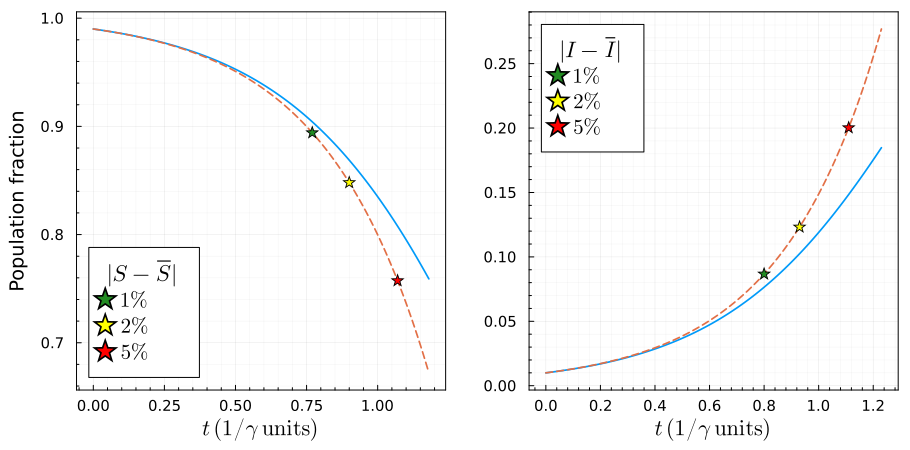

In [7]:
# General single-plot attributes
kw =(;
    xlabel="\$ t \\; (1/\\gamma \\; \\mathrm{units}) \$",
    xminorgrid=true,
    yminorgrid=true,
    yminorticks=5,
    xlabelfontsize=15,
    ylabelfontsize=13,  # Default value is 11.
    legendfontsize=14,
    legendtitlefontsize=15,
    tickfontsize=10,
    framestyle=:box,
    dpi=400,
    size=(450, 450)
)


my_plots = make_plots(num_sols.t, num_sols[1:2, :], apx_sols, ϵ_list, ids, kw)

final_plot = plot(my_plots[1], my_plots[2], layout=(1, 2), size=(910, 450), 
                    left_margin=5Plots.mm, bottom_margin=5Plots.mm)

# You've met with a terrible fate, haven't you?

# savefig(final_plot, "Plots/prob1_a_R0_$(R0).png")

## 3. Single-error-value analysis

### $R_{0}$ vs. $t(\epsilon)$ for different initial conditions $S_{0}$.

### [Go back to the beginning](#Compartmental-models-for-disease-spread:-Outbreak)

In [2]:
##########################################################
# Lists of initial values and basic reproduction numbers #
##########################################################

s0_values = [0.9, 0.95, 0.98, 0.99]
R0_values = 0.7:0.01:2
ϵ = 0.01


ϵ_list = [ϵ]

s0_times = []

for s0 ∈ s0_values
    
    times = []
    
    i0 = 1 - s0
    
    for R0 ∈ R0_values
        num_sols, apx_sols = get_solutions(s0, i0, R0);
        s_ids, i_ids = get_error_ids(num_sols, apx_sols, ϵ_list);
        
        if isempty(s_ids)
            push!(times, NaN)
            continue
        end
        
        push!(times, num_sols.t[minimum(s_ids)])
        
    end
    
    push!(s0_times, times)
end

In [5]:
# General plot attributes
kw =(;
    xlabel="\$ R_{0} \$",
    ylabel="\$ t(ϵ = 1\\%)\$",
    xticks=0.8:0.2:2,
    yticks=0:5:20,
    xminorgrid=true,
    yminorgrid=true,
    xminorticks=4,
    yminorticks=5,
    xlabelfontsize=15,
    ylabelfontsize=15,  # Default value is 11.
    legendfontsize=14,
    legendtitlefontsize=15,
    tickfontsize=10,
    framestyle=:box,
    dpi=400,
    size=(450, 450)
)

labels = ["\$ $(s0)\$" for s0 ∈ s0_values]
labels = reduce(hcat, labels)

plotb = plot(R0_values, [s0_times[:]], lw=2, label=labels, legendtitle="\$ S_{0} \$"; kw...)
# savefig(plotb, "Plots/prob1_a_R0_t.png")

"/Users/vgranados/Documents/Master_Physics/Advanced Computational Physics/Priesemann_Project/Plots/problem_1a_R0_t.png"